# STATS 542: Homework 6

<h4><center> Diego Kleiman (diegoek2) </center></h4>
<h4><center> Due: Tuesday 11:59 PM CT, Mar 16th </center></h4>

## About HW6

This is a relatively light homework. The main purpose is to understand how the spline basis is constructed. We will use the `Ozone` data from the `mlbench` package. Univariate analysis is considered in Q1a, while multivariate analysis is considered in Q1b. 

# Question 1 [100 Points] Write Your Own Spline Basis

We will fit and compare different spline models to the `Ozone` dataset form the `mlbench` package. The dataset is already ordered by date, and we will use this index as the $x$ variable, named as `time`. 

```{r}
  library(mlbench)
  data(Ozone)
  
  # Wind will only be used for Q2
  mydata = data.frame("time" = seq(1:nrow(Ozone))/nrow(Ozone), "ozone" = Ozone$V4, "wind" = Ozone$V6)
  
  trainid = sample(1:nrow(Ozone), 250)
  train = mydata[trainid, ]
  test = mydata[-trainid, ]
  par(mfrow=c(1,2))
  
  plot(train$time, train$ozone, pch = 19, cex = 0.5)
  plot(trainwind, trainozone, pch = 19, cex = 0.5)
```

In [1]:
import os
os.environ['R_HOME'] = "/Users/diegoeduardo/opt/anaconda3/envs/R/lib/R"

In [2]:
from rpy2.robjects.packages import importr, data
import numpy as np
import pandas as pd

mlbench = importr("mlbench")
r_env_data_object = data(mlbench).fetch("Ozone")
ozone_data = pd.DataFrame(r_env_data_object["Ozone"]) 
ozone_data_array = np.asarray(ozone_data)

nrow = ozone_data_array.shape[1] # Apparently samples are indexed by column and not by row
time = np.linspace(1, nrow, nrow)/nrow
ozone = ozone_data_array[3, :] # Index 3 corresponds to 4th variable
wind = ozone_data_array[5, :] # Index 5 corresponds to 6th variable

colnames = ["time", "ozone", "wind"]
my_data = pd.DataFrame(np.asarray([time, ozone, wind]).T, columns=colnames)

np.random.seed(1) # Seed
trainid = np.random.choice(nrow, size=250, replace=False)

# Data design note: I have eliminated all rows with nan's
train = my_data.iloc[trainid].sort_index().dropna()
test = my_data.iloc[~my_data.index.isin(trainid)].dropna()

Check data looks correct

In [3]:
train

,time,ozone,wind
0,0.002732,3.0,8.0
4,0.013661,5.0,3.0
5,0.016393,6.0,4.0
6,0.019126,4.0,6.0
8,0.024590,6.0,3.0
...,...,...,...
360,0.986339,3.0,7.0
362,0.991803,3.0,3.0
363,0.994536,5.0,3.0
364,0.997268,1.0,4.0


In [4]:
test

,time,ozone,wind
1,0.005464,3.0,6.0
2,0.008197,3.0,4.0
3,0.010929,5.0,3.0
7,0.021858,4.0,3.0
10,0.030055,4.0,8.0
...,...,...,...
339,0.928962,6.0,0.0
343,0.939891,7.0,0.0
354,0.969945,6.0,3.0
356,0.975410,4.0,4.0


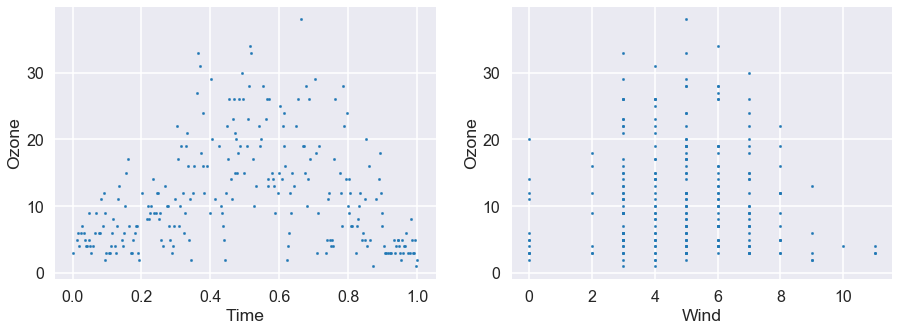

In [7]:
from matplotlib import pyplot as plt
plt.style.use('seaborn-poster')
plt.style.use('seaborn-darkgrid')
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].scatter(train.time, train.ozone, s=5)
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Ozone")
axes[1].scatter(train.wind, train.ozone, s=5)
axes[1].set_xlabel("Wind")
axes[1].set_ylabel("Ozone")
plt.show()
plt.close()

## a. [80 points] Univariate Spline Fit

Let's consider several different spline methods to model the `ozone` level using `time`. To test your model, use the train/test split provided above. If you use Python, please generate your split with the same mechanism and save your seed. Use the mean squared error as the metric for evaluation and report it for each method. For the basis that you write with your own code, make sure to include the intercept term. For each method, produce a figure consists of training data, testing data and your fitted curve.

  * (i) Write your own code (you cannot use `bs()` or similar functions) to implement a continuous piecewise linear fitting. Pick 3 knots using your own judgment.
  * (ii) Write your own code to implement a quadratic spline fitting. Your spline should be continuous up to the first derivative. Pick 4 knots using your own judgment.
  * (iii) Produce a same set of basis as (ii) using the `bs()` function. Note that they do not have to be exactly the same as yours. Verify (figure out how) that the column spaces are the same. 
  * Use existing functions (e.g. `ns()`)to implement a natural cubic spline with 6 knots. Choose your own knots.
  * Use existing functions to implement a smoothing spline. Use the built-in generalized cross-validation method to select the best tuning parameter.

**Note about knots placement:** I decided to use evenly spaced knots in the range of the variable $x$. According to the sources I read, this is usually called "cardinal" B-spline and it is a pretty common choice. In fact, it is the default in the Python module Scikit-learn.

### Part (i)

In [6]:
def pcws_linear(x, y, n_knots=3):
    '''
    Returns a fitted continuous piecewise linear model for univariate data x and outcomes y. 
    The number of (internal) knots is given by n_knots (default 3) and these are evenly spaced across the range of x.
    The resulting model includes an intercept term.
    The training MSE is also computed and returned.
    
    Arguments
    ---------------------
    x: np.ndarray of shape (n_samples, 1) or (n_samples,). Univariate training data.
    y: np.ndarray of shape (n_samples, 1) or (n_samples,). Outcomes for training data.
    n_knots: int. Number of knots. Default n_knots=3.
    
    Returns
    ---------------------
    model: function. A callable that returns the predicted value for a given x.
    MSE: float. Fitting error for training data.
    '''
    n_samples = x.shape[0]
    knots = np.linspace(x.min(), x.max(), n_knots+2)[1:-1] # Select knots to be evenly spaced in range of x
    
    # Construct new design matrix based on number of knots
    h0 = np.ones(n_samples)
    h1 = x
    hm = np.empty((n_samples, n_knots))
    for m, knot in enumerate(knots):
        hm[:, m] = np.piecewise(x, [x <= knot, x > knot], [0, lambda x: x-knot])
    
    # Put everything together in design matrix
    X = np.append(np.append(h0[:, None], h1[:, None], axis=1), hm, axis=1) 
    
    # Fit linear model using OLS
    beta = np.matmul(np.linalg.inv(np.matmul(X.T, X)), np.matmul(X.T, y))
    y_hat = np.matmul(X, beta)
    MSE = np.mean((y-y_hat)**2)
    
    model = model_wrapper_pcws_linear(beta, knots)
    
    return model, MSE
    
def model_wrapper_pcws_linear(beta, knots):
    '''
    Helper function to construct callable object model.
    '''
    
    def model(x):
        n_samples = x.shape[0]
        n_knots = knots.shape[0]
        h0 = np.ones(n_samples)
        h1 = x
        hm = np.empty((n_samples, n_knots))
        for m, knot in enumerate(knots):
            hm[:, m] = np.piecewise(x, [x <= knot, x > knot], [0, lambda x: x-knot])
        X = np.append(np.append(h0[:, None], h1[:, None], axis=1), hm, axis=1) 
        y_hat = np.matmul(X, beta)
        
        return y_hat
    
    return model

Testing my function with dummy data

In [7]:
x_dummy = np.linspace(1, 10, 16)
y_dummy = np.asarray([1, 10, 20, 30, 40, 40, 40, 40, 40, 30, 20, 10, 5, 1, 1, 1])
model_dummy, MSE_dummy = pcws_linear(x_dummy, y_dummy)

In [8]:
print(MSE_dummy)

1.610647539052588


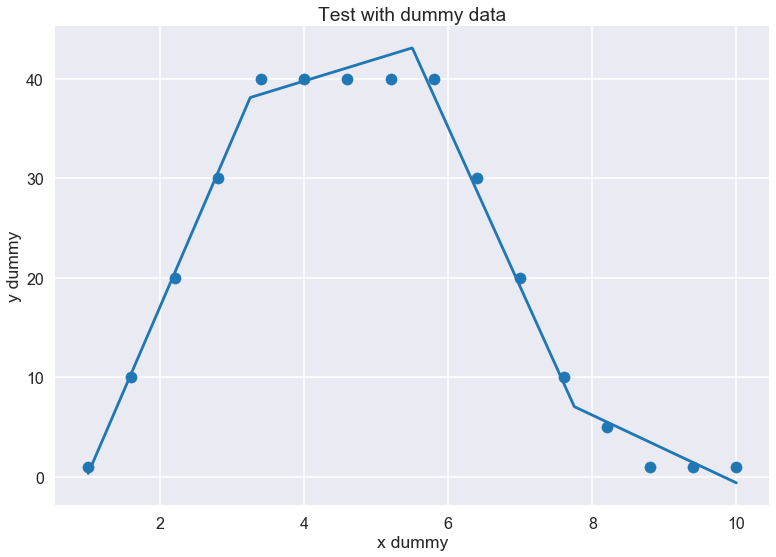

In [9]:
plt.scatter(x_dummy, y_dummy)
line = np.linspace(1, 10, 1000)
y_line = model_dummy(line)
plt.plot(line, y_line)
plt.title("Test with dummy data")
plt.xlabel("x dummy")
plt.ylabel("y dummy")
plt.show()
plt.close()

Fitting the actual data

In [10]:
model_pcws_linear, MSE_train_pcws_linear = pcws_linear(np.asarray(train.time), np.asarray(train.ozone))
test_predictions_pcws_linear = model_pcws_linear(np.asarray(test.time))
MSE_test_pcws_linear = np.mean((test_predictions_pcws_linear-np.asarray(test.ozone))**2)

print("Train MSE (piecewise linear):", MSE_train_pcws_linear)
print("Test MSE (piecewise linear):", MSE_test_pcws_linear)

Train MSE (piecewise linear): 35.61268682100516
Test MSE (piecewise linear): 41.60505143555171


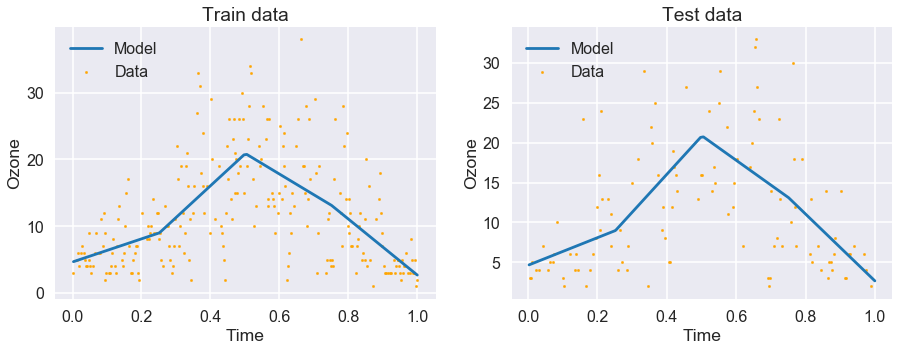

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].scatter(train.time, train.ozone, s=5, c='orange')
axes[0].plot(train.time, model_pcws_linear(np.asarray(train.time)))
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Ozone")
axes[0].set_title("Train data")
axes[0].legend(["Model", "Data"], loc='upper left')
axes[1].scatter(test.time, test.ozone, s=5, c='orange')
axes[1].plot(train.time, model_pcws_linear(np.asarray(train.time)))
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Ozone")
axes[1].set_title("Test data")
axes[1].legend(["Model", "Data"])
plt.show()
plt.close()

### Part (ii)

In [12]:
def quad_spline(x, y, n_knots=4):
    '''
    Returns a fitted quadratic spline model for univariate data x and outcomes y. 
    The number of (internal) knots is given by n_knots (default 4) and these are evenly spaced across the range of x.
    The resulting model includes an intercept term.
    The training MSE is also computed and returned.
    
    Arguments
    ---------------------
    x: np.ndarray of shape (n_samples, 1) or (n_samples,). Univariate training data.
    y: np.ndarray of shape (n_samples, 1) or (n_samples,). Outcomes for training data.
    n_knots: int. Number of knots. Default n_knots=4.
    
    Returns
    ---------------------
    model: function. A callable that returns the predicted value for a given x.
    MSE: float. Fitting error for training data.
    '''
    n_samples = x.shape[0]
    knots = np.linspace(x.min(), x.max(), n_knots+2)[1:-1] # Select knots to be evenly spaced in range of x
    
    # Construct new design matrix based on number of knots
    h0 = np.ones(n_samples)
    h1 = x
    h2 = x**2
    hm = np.empty((n_samples, n_knots))
    for m, knot in enumerate(knots):
        hm[:, m] = np.piecewise(x, [x <= knot, x > knot], [0, lambda x: (x-knot)**2])
    
    # Put everything together in design matrix
    X = np.empty((n_samples, n_knots+3))
    X[:, 0] = h0
    X[:, 1] = h1
    X[:, 2] = h2
    X[:, 3:] = hm
    
    # Fit linear model using OLS
    beta = np.matmul(np.linalg.inv(np.matmul(X.T, X)), np.matmul(X.T, y))
    y_hat = np.matmul(X, beta)
    MSE = np.mean((y-y_hat)**2)
    
    model = model_wrapper_quad_spline(beta, knots)
    
    return model, MSE
    
def model_wrapper_quad_spline(beta, knots):
    '''
    Helper function to construct callable object model.
    '''
    
    def model(x):
        n_samples = x.shape[0]
        n_knots = knots.shape[0]
        h0 = np.ones(n_samples)
        h1 = x
        h2 = x**2
        hm = np.empty((n_samples, n_knots))
        for m, knot in enumerate(knots):
            hm[:, m] = np.piecewise(x, [x <= knot, x > knot], [0, lambda x: (x-knot)**2])
        X = np.empty((n_samples, n_knots+3))
        X[:, 0] = h0
        X[:, 1] = h1
        X[:, 2] = h2
        X[:, 3:] = hm
        y_hat = np.matmul(X, beta)
        
        return y_hat
    
    return model

In [13]:
model_quad_spline, MSE_train_quad_spline = quad_spline(np.asarray(train.time), np.asarray(train.ozone))
test_predictions_quad_spline = model_quad_spline(np.asarray(test.time))
MSE_test_quad_spline = np.mean((test_predictions_quad_spline-np.asarray(test.ozone))**2)

print("Train MSE (quadratic spline):", MSE_train_quad_spline)
print("Test MSE (quadratic spline):", MSE_test_quad_spline)

Train MSE (quadratic spline): 36.08742895947224
Test MSE (quadratic spline): 41.529592880779894


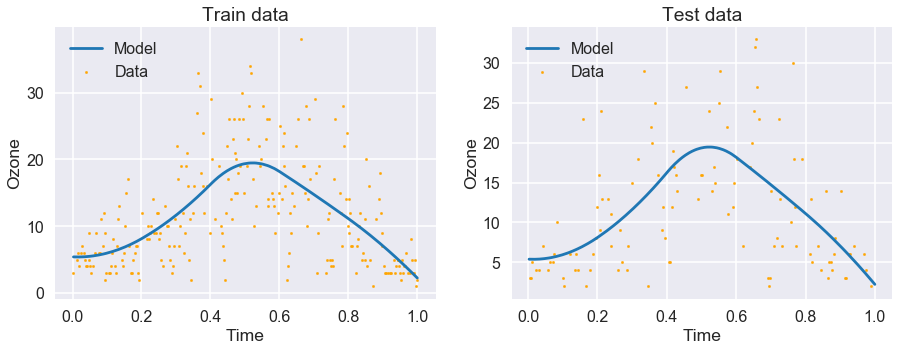

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].scatter(train.time, train.ozone, s=5, c='orange')
axes[0].plot(train.time, model_quad_spline(np.asarray(train.time)))
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Ozone")
axes[0].set_title("Train data")
axes[0].legend(["Model", "Data"], loc='upper left')
axes[1].scatter(test.time, test.ozone, s=5, c='orange')
axes[1].plot(train.time, model_quad_spline(np.asarray(train.time)))
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Ozone")
axes[1].set_title("Test data")
axes[1].legend(["Model", "Data"])
plt.show()
plt.close()

### Part (iii)

We can show that the column spaces of two matrices are the same if the rank of their combined columns is the same as the rank of each matrix individually. In other terms, if we have matrices $A$ and $B$, let $C = [A\space B]$. Then, $A$ and $B$ have the same column space if $Rank(A) = Rank(B) = Rank(C)$.

In [15]:
from sklearn.preprocessing import SplineTransformer

In [16]:
# Note: I use 4+2 in n_knots because the sklearn function includes boundary knots (but I want 4 internal knots)
spline = SplineTransformer(n_knots=4+2, degree=2, include_bias=True) 
quad_basis_sklearn = spline.fit_transform(np.asarray(train.time).reshape(-1, 1), np.asarray(train.ozone))

In [17]:
# The basis from my function (I copied and pasted to extract my basis)
x = np.asarray(train.time)
n_samples = x.shape[0]
n_knots = 4
knots = np.linspace(x.min(), x.max(), n_knots+2)[1:-1] # Select knots to be evenly spaced in range of x

# Construct new design matrix based on number of knots
h0 = np.ones(n_samples)
h1 = x
h2 = x**2
hm = np.empty((n_samples, n_knots))
for m, knot in enumerate(knots):
    hm[:, m] = np.piecewise(x, [x <= knot, x > knot], [0, lambda x: (x-knot)**2])

# Put everything together in design matrix
X = np.empty((n_samples, n_knots+3))
X[:, 0] = h0
X[:, 1] = h1
X[:, 2] = h2
X[:, 3:] = hm

my_quad_basis = X

In [18]:
A_rank = np.linalg.matrix_rank(my_quad_basis)
B_rank = np.linalg.matrix_rank(quad_basis_sklearn)
C_rank = np.linalg.matrix_rank(np.append(my_quad_basis, quad_basis_sklearn, axis=1))
print(A_rank == B_rank == C_rank)

True


Conclusion: the column spaces are the same.

### Implement a natural cubic spline with 6 knots (using existing functions)

In [3]:
import patsy # Will use for natural cubic spline basis

In [4]:
def natural_cubic_spline(x, y, n_knots=6):
    '''
    Returns a fitted natural cubic spline model for univariate data x and outcomes y. 
    The number of (internal) knots is given by n_knots (default 6) and these are evenly spaced across the range of x.
    The resulting model includes an intercept term.
    The training MSE is also computed and returned.
    
    Arguments
    ---------------------
    x: np.ndarray of shape (n_samples, 1) or (n_samples,). Univariate training data.
    y: np.ndarray of shape (n_samples, 1) or (n_samples,). Outcomes for training data.
    n_knots: int. Number of knots. Default n_knots=6.
    
    Returns
    ---------------------
    model: function. A callable that returns the predicted value for a given x.
    MSE: float. Fitting error for training data.
    '''
    
    X = patsy.cr(x, df=n_knots)
    
    # Fit linear model using OLS
    beta = np.matmul(np.linalg.inv(np.matmul(X.T, X)), np.matmul(X.T, y))
    y_hat = np.matmul(X, beta)
    MSE = np.mean((y-y_hat)**2)
    
    model = model_wrapper_natural_cubic_spline(beta, n_knots)
    
    return model, MSE
    
def model_wrapper_natural_cubic_spline(beta, n_knots):
    '''
    Helper function to construct callable object model.
    '''
    
    def model(x):
        X = patsy.cr(x, df=n_knots)
        y_hat = np.matmul(X, beta)
        
        return y_hat
    
    return model

In [5]:
model_natural_cubic_spline, MSE_train_natural_cubic_spline = natural_cubic_spline(np.asarray(train.time), 
                                                                                  np.asarray(train.ozone))
test_predictions_natural_cubic_spline = model_natural_cubic_spline(np.asarray(test.time))
MSE_test_natural_cubic_spline = np.mean((test_predictions_natural_cubic_spline-np.asarray(test.ozone))**2)

print("Train MSE (natural cubic spline):", MSE_train_natural_cubic_spline)
print("Test MSE (natural cubic spline):", MSE_test_natural_cubic_spline)

Train MSE (natural cubic spline): 36.062389959633116
Test MSE (natural cubic spline): 42.232188808621416


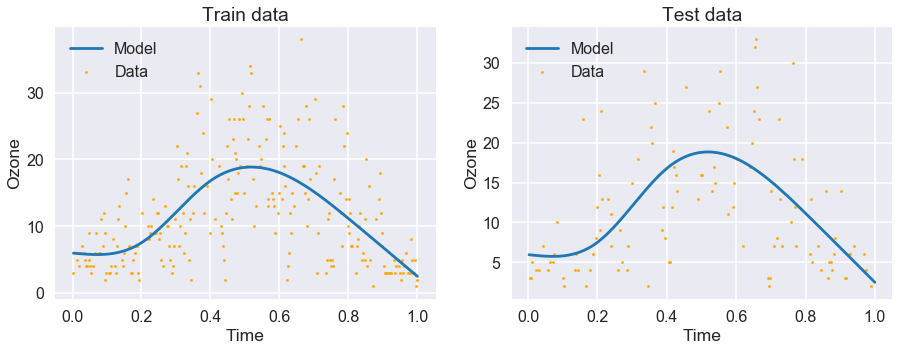

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].scatter(train.time, train.ozone, s=5, c='orange')
axes[0].plot(train.time, model_natural_cubic_spline(np.asarray(train.time)))
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Ozone")
axes[0].set_title("Train data")
axes[0].legend(["Model", "Data"], loc='upper left')
axes[1].scatter(test.time, test.ozone, s=5, c='orange')
axes[1].plot(train.time, model_natural_cubic_spline(np.asarray(train.time)))
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Ozone")
axes[1].set_title("Test data")
axes[1].legend(["Model", "Data"])
plt.show()
plt.close()

In [33]:
X = patsy.cr(np.asarray(train.time), knots=np.linspace(train.time.min(), train.time.max(), 6)[1:-2])

In [35]:
X

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 9.30595130e-01,  8.78266156e-02, -2.28683735e-02,
         4.76424448e-03, -3.17616298e-04],
       [ 9.13274849e-01,  1.09713326e-01, -2.85370443e-02,
         5.94521756e-03, -3.96347837e-04],
       ...,
       [-6.37026026e-04,  3.82215615e-03, -1.52886246e-02,
         3.05798198e-02,  9.81523675e-01],
       [-3.18557849e-04,  1.91134709e-03, -7.64538837e-03,
         1.52910981e-02,  9.90761501e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00]])

In [25]:
patsy.cr?

Signature: patsy.cr()
Docstring:
cr(x, df=None, knots=None, lower_bound=None, upper_bound=None, constraints=None)

Generates a natural cubic spline basis for ``x``
(with the option of absorbing centering or more general parameters
constraints), allowing non-linear fits. The usual usage is something like::

  y ~ 1 + cr(x, df=5, constraints='center')

to fit ``y`` as a smooth function of ``x``, with 5 degrees of freedom
given to the smooth, and centering constraint absorbed in
the resulting design matrix. Note that in this example, due to the centering
constraint, 6 knots will get computed from the input data ``x``
to achieve 5 degrees of freedom.


.. note:: This function reproduce the cubic regression splines 'cr' and 'cs'
  as implemented in the R package 'mgcv' (GAM modelling).


:arg df: The number of degrees of freedom to use for this spline. The
  return value will have this many columns. You must specify at least one
  of ``df`` and ``knots``.
:arg knots: The interior knots to u

### Implement a smoothing spline (using existing functions)

In [23]:
# There is no implementation in Python yet, so I will use R here (with the interface rpy2)
from rpy2.robjects import numpy2ri
numpy2ri.activate() # Convert numpy arrays to R vectors automatically

stats = importr("stats")
smoothing_spline = stats.smooth_spline(np.asarray(train.time), np.asarray(train.ozone))
train_predictions = np.asarray(stats.predict(smoothing_spline, np.asarray(train.time))[1])
test_predictions = np.asarray(stats.predict(smoothing_spline, np.asarray(test.time))[1])
numpy2ri.deactivate()

In [24]:
optimal_lambda = np.asarray(smoothing_spline[list(smoothing_spline.names).index('lambda')])[0]
print("Lambda selected with GCV:", optimal_lambda)

Lambda selected with GCV: 4.475961982238944e-08


In [25]:
MSE_train_smooth_spline = np.mean((train_predictions-np.asarray(train.ozone))**2)
MSE_test_smooth_spline = np.mean((test_predictions-np.asarray(test.ozone))**2)
print("Train MSE (smooth spline):", MSE_train_smooth_spline)
print("Test MSE (smooth spline):", MSE_test_smooth_spline)

Train MSE (smooth spline): 12.889528622194158
Test MSE (smooth spline): 33.35406879526895


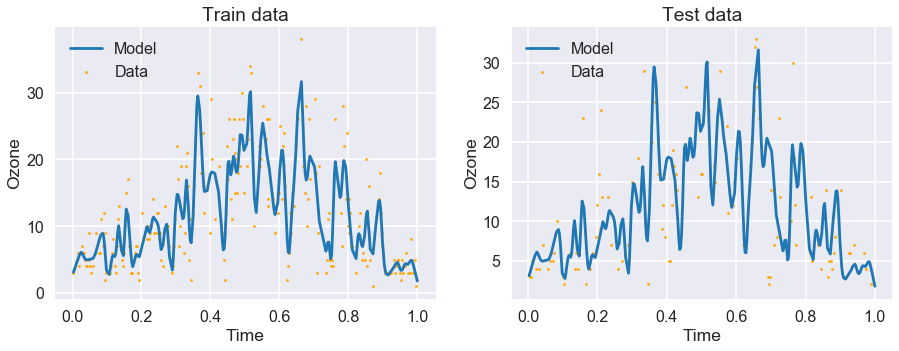

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].scatter(train.time, train.ozone, s=5, c='orange')
axes[0].plot(train.time, train_predictions)
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Ozone")
axes[0].set_title("Train data")
axes[0].legend(["Model", "Data"], loc='upper left')
axes[1].scatter(test.time, test.ozone, s=5, c='orange')
axes[1].plot(train.time, train_predictions)
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Ozone")
axes[1].set_title("Test data")
axes[1].legend(["Model", "Data"])
plt.show()
plt.close()

This was the result using the default GCV.

## b. [20 points] Multivariate Spline Fit With Additive Structure

Consider using both `time` and `wind` as the covariate. Use the additive model structure, with continuous piecewise linear for time and quadratic spline for wind. Both should be done using the code you developed previously. Pick your number of knots, but no more than 5. Fit and predict the `ozone` outcome and report the prediction error. 

Note: I used the code that I developed previously, but I don't call the functions I defined before explicitly.

In [27]:
def bivariate_spline(x1, x2, y, n_knots=[4, 4]):
    """
    Fits bivariate spline using two covariates (x1 and x2) and outcomes y. 
    The basis functions computed from x1 are piecewise linear and those computed from x2 are quadratic.
    n_knots is an iterable of size 2 containing the number of (internal) knots to use with each variable.
    Arguments
    ---------------------
    x1: np.ndarray of shape (n_samples, 1) or (n_samples,). First variable of training data.
    x2: np.ndarray of shape (n_samples, 1) or (n_samples,). Second variable of training data.
    y: np.ndarray of shape (n_samples, 1) or (n_samples,). Outcomes for training data.
    n_knots: iterable containing ints. Number of knots. Default n_knots=[4, 4].
    
    Returns
    ---------------------
    model: function. A callable that returns the predicted value for a given x.
    MSE: float. Fitting error for training data.
    """
    assert(x1.shape[0] == x2.shape[0] == y.shape[0])
    
    n_samples = x1.shape[0]
    knots1 = np.linspace(x1.min(), x1.max(), n_knots[0]+2)[1:-1] # Select knots to be evenly spaced in range of x1
    knots2 = np.linspace(x2.min(), x2.max(), n_knots[1]+2)[1:-1] # Select knots to be evenly spaced in range of x2
    
    # Construct piecewise linear design matrix
    h0 = np.ones(n_samples) # Intercept term only shows up once
    h1 = x1
    hm = np.empty((n_samples, n_knots[0]))
    for m, knot in enumerate(knots1):
        hm[:, m] = np.piecewise(x1, [x1 <= knot, x1 > knot], [0, lambda x1: x1-knot])
    X1 = np.empty((n_samples, n_knots[0]+2))
    X1[:, 0] = h0
    X1[:, 1] = h1
    X1[:, 2:] = hm
    
    # Construct quadratic spline design matrix
    h1 = x2
    h2 = x2**2
    hm = np.empty((n_samples, n_knots[1]))
    for m, knot in enumerate(knots2):
        hm[:, m] = np.piecewise(x2, [x2 <= knot, x2 > knot], [0, lambda x2: (x2-knot)**2])
    X2 = np.empty((n_samples, n_knots[1]+2))
    X2[:, 0] = h1
    X2[:, 1] = h2
    X2[:, 2:] = hm
    
    X = np.append(X1, X2, axis=1)
    
    # Fit linear model using OLS
    beta = np.matmul(np.linalg.inv(np.matmul(X.T, X)), np.matmul(X.T, y))
    y_hat = np.matmul(X, beta)
    MSE = np.mean((y-y_hat)**2)
    
    model = model_wrapper_bivariate_spline(beta, knots1, knots2)
    
    return model, MSE

def model_wrapper_bivariate_spline(beta, knots1, knots2):
    '''
    Helper function to construct callable object model.
    '''
    
    def model(x1, x2):
        n_samples = x1.shape[0]
        n_knots1 = knots1.shape[0]
        n_knots2 = knots2.shape[0]
        
        h0 = np.ones(n_samples)
        h1 = x1
        hm = np.empty((n_samples, n_knots1))
        for m, knot in enumerate(knots1):
            hm[:, m] = np.piecewise(x1, [x1 <= knot, x1 > knot], [0, lambda x1: x1-knot])
        X1 = np.empty((n_samples, n_knots1+2))
        X1[:, 0] = h0
        X1[:, 1] = h1
        X1[:, 2:] = hm

        h1 = x2
        h2 = x2**2
        hm = np.empty((n_samples, n_knots2))
        for m, knot in enumerate(knots2):
            hm[:, m] = np.piecewise(x2, [x2 <= knot, x2 > knot], [0, lambda x2: (x2-knot)**2])
        X2 = np.empty((n_samples, n_knots2+2))
        X2[:, 0] = h1
        X2[:, 1] = h2
        X2[:, 2:] = hm
        
        X = np.append(X1, X2, axis=1)
        y_hat = np.matmul(X, beta)
        
        return y_hat
    
    return model

In [28]:
model_bivariate_spline, MSE_train_bivariate_spline = bivariate_spline(np.asarray(train.time), 
                                                                              np.asarray(train.wind),
                                                                              np.asarray(train.ozone),
                                                                     n_knots=[3, 2])
test_predictions_bivariate_spline = model_bivariate_spline(np.asarray(test.time), np.asarray(test.wind))
MSE_test_bivariate_spline = np.mean((test_predictions_bivariate_spline-np.asarray(test.ozone))**2)

print("Train MSE (bivariate spline):", MSE_train_bivariate_spline)
print("Test MSE (bivariate spline):", MSE_test_bivariate_spline)

Train MSE (bivariate spline): 32.72486248629082
Test MSE (bivariate spline): 39.4355215507936


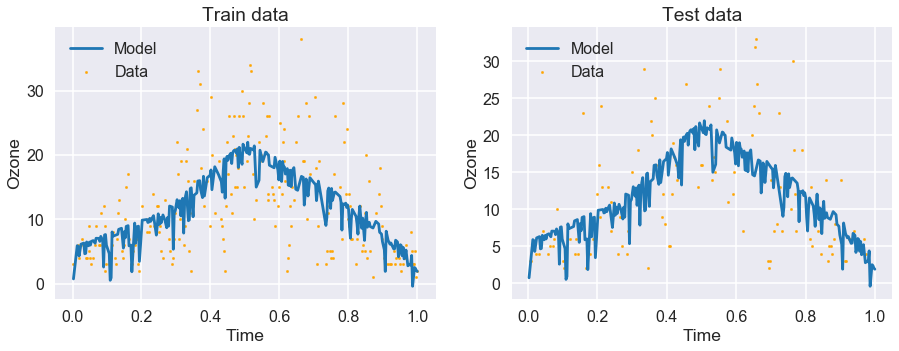

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].scatter(train.time, train.ozone, s=5, c='orange')
axes[0].plot(train.time, model_bivariate_spline(np.asarray(train.time), np.asarray(train.wind)))
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Ozone")
axes[0].set_title("Train data")
axes[0].legend(["Model", "Data"], loc='upper left')
axes[1].scatter(test.time, test.ozone, s=5, c='orange')
axes[1].plot(train.time, model_bivariate_spline(np.asarray(train.time), np.asarray(train.wind)))
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Ozone")
axes[1].set_title("Test data")
axes[1].legend(["Model", "Data"])
plt.show()
plt.close()

**Conclusions:**

The model with the lowest MSE was the smoothing spline. Since that model was constructed using GCV, the tuning parameter $\lambda$ was optimized and hence we obtained a better performance. However, it is clear that the model is overfitting: the train MSE is much lower than the test MSE. It is also apparent that the optimal $\lambda$ value is very small, so the resulting curve is rough.

I was expecting the bivariate model to perform better because we added an extra predictor (wind). However, it seems that the model is overfitting the data. Probably if we run a predictor selection algorithm, such as backward selection, on the basis functions used for the bivariate model, we would have obtained a better model.